In [2]:
import string
import re
import pickle
import ipdb
import itertools
from collections import Counter

import os, codecs, string, random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
import langid

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')



from gensim.corpora.dictionary import Dictionary
from gensim.models import TfidfModel
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paola.YELA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Paola.YELA\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Paola.YELA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# A. FromTxtData_ToSuggestedTags

This notebook uses as input the _descriptors actions_ file (which contains the different tags) and the files in the folder _data/data simplified_ that contains the source documents in txt format.

The NLP and ML pipeline was taken from the Github account of Navid Rekabsaz.

## 1) Creation of baseline dataset

### 1.1) Merging of relevant datasets

Load the VCA reports

In [3]:
corpus_root = 'data/'

In [4]:
reports = list()
reports_title = list()
for report_file in (os.listdir(corpus_root+'data_simplified/Asia Pacific/Philippines/All reports')):
    if ".txt" in report_file:
        with codecs.open(os.path.join(corpus_root+'data_simplified/Asia Pacific/Philippines/All Reports',report_file),encoding="utf8", errors='ignore') as f:
            reports.append(f.read())
            reports_title.append(report_file)

In [5]:
content = pd.DataFrame()
content['Lead Title'] = reports_title
content['Lead Title'] = content['Lead Title'].str.replace('.txt','')
content['Content Report'] = reports
print('Number of documents found: ',len(content))
content.sample(3)

Number of documents found:  89


,Lead Title,Content Report
13,Barangay Bakhaw Sur_2018-09-27_05-56-34,Philippine Red Cross Aklan Chapter\r\n\r\nVul...
28,Kiling CAP output,Three (3) Years 2014-2017\r\n\r\n\r\nIn partne...
9,Aslum PRA Outputs landscape,"Barangay , Alang-alang, Leyte\r\n\r\nBarangay ..."


Load dataset with labels and remove extensions from file names in order to easily merge them with the _content_ dataset

In [6]:
labels = pd.read_excel(corpus_root + 'data_preprocessed/Asia Pacific/Philippines/descriptors_actions.xlsx',encoding="utf-8")
labels['Report Title'] = labels['Report Title'].str.replace('.docx','')
labels['Report Title'] = labels['Report Title'].str.replace('.doc','')
labels['Report Title'] = labels['Report Title'].str.replace('.pdf','')
labels['Planned Action Title'] = labels['Planned Action Title'].str.replace('.docx','')
labels['Planned Action Title'] = labels['Planned Action Title'].str.replace('.doc','')
labels['Planned Action Title'] = labels['Planned Action Title'].str.replace('.pdf','')
labels.sample()

,Country,Province,Municipality,Name of Community,Hazards,Livelihood Activities,Type of context,Geophysical environment,VCA tools used,Source,...,German Red Cross,Finnish Red Cross,American Red Cross,Norwegian Red Cross,Excerpt,Number of planned actions,Action 1,Action 2,Action 3,Planned Action Title
24,Philippines,Camarines Norte,Santa Elena,Polungguitguit,"Cyclones, Floods, Drought, Diseases, Other, Fires","Agriculture, Fishery and Aquaculture, Forestry...",Rural,"Coastal, Lowland","Transect walk, Mapping, Direct observation, Hi...",Philippine Red Cross and Spanish Red Cross,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Merging both datasets

In [7]:
baseline = pd.merge(content, labels,  how='right', left_on ='Lead Title', right_on = 'Planned Action Title')
baseline = baseline.rename(columns = {'Content Report': 'Planned Action Text'})
baseline = baseline.drop(columns = 'Lead Title')
baseline = pd.merge(content, baseline,  how='right', left_on ='Lead Title', right_on = 'Report Title')
baseline = baseline.rename(columns = {'Content Report': 'Report Text'})
baseline = baseline.drop(columns = 'Lead Title')
baseline.sample(3)

,Report Text,Planned Action Text,Country,Province,Municipality,Name of Community,Hazards,Livelihood Activities,Type of context,Geophysical environment,...,German Red Cross,Finnish Red Cross,American Red Cross,Norwegian Red Cross,Excerpt,Number of planned actions,Action 1,Action 2,Action 3,Planned Action Title
18,"Barangay , Alang-alang, Leyte\r\n\r\nBarangay ...",Three (3) Years 2014-2017\r\n\r\n\r\nThree (3)...,Philippines,Leyte,Alangalang,Hubang,"Floods, Cyclones, Diseases, El niño/La niña","Agriculture, Forestry",Rural,Lowland,...,0,0,1,0,['Provided the following alternative livelihoo...,7.0,Constructed core shelter for 220 totally damag...,Constructed Drainage for: - Proper 1 - P...,150 Households have accessed to latrines,Hubang CAP output
56,Empowering Communities and Local Government Un...,Empowering Communities and Local Government Un...,Philippines,Antique,Hamtic,Malandog,"Cyclones, Floods, Road accidents, Fires","Agriculture, Fishery and Aquaculture",Rural,"Coastal, Lowland",...,1,0,0,0,['Capacity Building on Basic Life support and ...,4.0,Repair and Rehabilitation of Evacuation Center,Capacity Building on Basic Life support and Fi...,Make a Brgy Resolution requesting the Land Tra...,VCA REPORT Malandog with Action plan EDITED_20...
60,Project funded by the European Union \r\n\r\n\...,NaN,Philippines,Camarines Norte,Vinzons,Sabang,"Cyclones, Floods, Drought, Diseases, Fires","Agriculture, Fishery and Aquaculture, Forestry",Rural,"Coastal, Lowland",...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2) Text preprocessing 

Until this moment the _Report Text_ and _Planned Action Text_ features have the extracted text from the reports without any further preprocessing. In order to extract meaningful information from them, a preprocessing step is done using NLP techniques.

In [8]:
baseline['Report Text'][0][0:900]

'Philippine Red Cross  Aklan Chapter\r\n\r\nVulnerability \r\n\r\nCapacity\r\n\r\nAssessment Study\r\n\r\nBarangay BakhawNorte, Kalibo, Aklan\r\n\r\nPhilippine Red Cross  Aklan Chapter\r\n\r\nVulnerability \r\n\r\nCapacity\r\n\r\nAssessment Study\r\n\r\nBarangay BakhawNorte, Kalibo, Aklan\r\n\r\n\r\nIn Partnership with\r\n\r\n\r\nIn Partnership with\r\n\r\n\r\nA Project Supported by \r\n\r\n\r\nEuropean Union\r\n\r\n\r\nA Project Supported by \r\n\r\n\r\nEuropean Union\r\n\r\n\r\nThe information contained in this document was produced by the community members of Barangay Rosario, Malinao, Aklan, Philippines and validated by its Barangay Council as a result of the collected data from VCA facilitated by European Union Funded Project of the Philippine Red Cross Aklan Chapter for the benefit of this community to create a better Barangay Development Plans and may not be reproduced or used by any means without the written permission of the Philippine Red Cross.\r\n\r\nThe in'

Specifically, the following steps are taken:
1. Lemmatization
2. Remove punctuation but not numbers
3. Stop word removal
4. Join strings separated by a space
5. Converts the string into lower case characters
6. Converts everything into a string

In [9]:
nltk_wordnet_tag_map = {
    'NN': wn.NOUN,
    'NNS': wn.NOUN,
    'VBP': wn.VERB,
    'VBG': wn.VERB,
    'JJ': wn.ADJ,
}

from functools import reduce

def compose(*functions):
    def compose2(f1, f2):
        """Compose two functions"""
        return lambda *args: f1(f2(*args))
    return reduce(compose2, functions)

def lemmatize(row, lemmatizer=WordNetLemmatizer()):
    text = row
    splitted = text if type(text) == list else str(text).split()
    splitted = list(map(lambda x: str(x).lower(), splitted))
    tagged = nltk.pos_tag(splitted)
    lemmatized = []
    for word, tag in tagged:
        wnet_tag = nltk_wordnet_tag_map.get(tag)
        if wnet_tag:
            lemmatized.append(lemmatizer.lemmatize(word, wnet_tag))
        else:
            lemmatized.append(word)
    return ' '.join(lemmatized)

def rm_punc_not_nums(inp, col=None):
    """Remove punctuation unless it's a number for either a df (and col)
    or single entry
    """
    punc = string.punctuation


    def sing_rm(phr):
        """Remove for a single entity"""
        return ' '.join([re.sub('\W+', '', i) if not (
                    all(j.isdigit() or j in punc for j in i)
                    and
                    any(j.isdigit() for j in i)
                ) else re.sub('\W+', '', i)
                for i in str(phr).split(' ')]
        )
    if col and isinstance(inp, pd.core.frame.DataFrame):
        return inp.filter(like=col).applymap(lambda phr: sing_rm(phr))
    elif isinstance(inp, str):
        return sing_rm(inp)
    else:
        raise Exception('Not a vaild type')


def rm_stop_words_txt(txt, swords=nltk.corpus.stopwords.words('english')):
    """ Remove stop words from given text """
    return ' '.join(
        [token for token in str(txt).split(' ')
            if token.lower() not in swords]
    )

def preprocessReport(row):
        inp = row["Report Text"]
        #print (inp)
        inp = lemmatize(inp)
        func = compose(
            rm_punc_not_nums,
            rm_stop_words_txt,
            ' '.join,
            str.split,
            str.lower,
            str
        )
        return func(inp)

def preprocessPOA(row):
        inp = row["Planned Action Text"]
        #print (inp)
        inp = lemmatize(inp)
        func = compose(
            rm_punc_not_nums,
            rm_stop_words_txt,
            ' '.join,
            str.split,
            str.lower,
            str
        )
        return func(inp)

print ('Testing...')
print (preprocessReport({"Report Text": "The 2 quick brown foxes jumped over the lazy dogs!"}))

Testing...
2 quick brown fox jumped lazy dogs


In [10]:
baseline['Report Preprocessed'] = baseline.apply(preprocessReport, axis=1)
baseline['Planned Action Preprocessed'] = baseline.apply(preprocessPOA, axis=1)
baseline.sample(3)

,Report Text,Planned Action Text,Country,Province,Municipality,Name of Community,Hazards,Livelihood Activities,Type of context,Geophysical environment,...,American Red Cross,Norwegian Red Cross,Excerpt,Number of planned actions,Action 1,Action 2,Action 3,Planned Action Title,Report Preprocessed,Planned Action Preprocessed
19,"Barangay , Mac Arthur, Leyte\r\n\r\nBarangay K...",Three (3) Years 2014-2017\r\n\r\n\r\nIn partne...,Philippines,Leyte,Macarthur,Kiling,"Conflict/Violence, Cyclones, Other, Floods, La...","Forestry, Agriculture",Rural,Mountain,...,1,0,"['Banana, corn, sweet potato, cassava, pechay,...",7.0,15 households provided with sanitary toilets,1km constructed concrete road from Brgy. Kilin...,Available facilities and medicines in the heal...,Kiling CAP output,barangay mac arthur leyte barangay kiling mac...,three 3 year 20142017 partnership barangay ma...
63,"Barangay , Mac Arthur, Leyte\r\n\r\nBarangay V...","Barangay , Mac Arthur, Leyte\r\n\r\nThree (3) ...",Philippines,Leyte,Macarthur,Villa Imelda,"Cyclones, Other, Floods, Landslides, Fires","Agriculture, Livestock, Fishery and Aquacultur...",Rural,"Lowland, Mountain",...,1,0,"['Livelihood assistance given to the farmers, ...",9.0,2 classrooms repaired and school facilities pr...,Clean Drinking Water Provided,Clean Drinking Water Provided,Villa Imelda CAP output,barangay mac arthur leyte barangay villa imel...,barangay mac arthur leyte three 3 year 201420...
24,"Barangay , Mac Arthur, Leyte\r\n\r\nBarangay S...","Barangay , Mac Arthur, Leyte\r\n\r\nThree (3) ...",Philippines,Leyte,Macarthur,San Isidro,"Floods, Earthquake, Cyclones, Diseases","Agriculture, Livestock, Forestry",Rural,Lowland,...,1,0,['210 households of Barangay San Isidro provid...,11.0,210 houses in Barangay San Isidro reconstruc-t...,Participation in every schistosomiasis mass tr...,350 m. road constructed,San Isidro CAP output,barangay mac arthur leyte barangay san isidro...,barangay mac arthur leyte three 3 year 201420...


In [162]:
baseline['Planned Action Preprocessed'][1]

'barangay 103a paglaum tacloban city leyte three 3 year 20142017 partnership community action plan overall goal make community barangay 103 progressive  resilient next three years objective target indicator project activity timeframe resource needed potential agency work budget source fund remark y1 y2 y3 local contribution loan grant provide sustainable livelihood 136 households provided necessary supply capital following alternative livelihoods 47 hhs rice farm 112 hhs vegetable  root crop farm 30 coconut farm 50 hhs livestock raise 18 sarisari store 1 mini eaterycarenderia 6 petty trader 5 sewer 20 motorcycle hire mch 8 cosmetology 2 physical therapist 30 peanut butter make  plan  proposal make  coordination agency  capacity building  implementation  monitoring x x x x x x paglaum farmer association manpower budget da dar red cross tesda city govt dole fao ilo us aid p 327 10000000  da 400 00000  dar 20 00000  tesda 5000000  dole 200 00000  city govt 1  red cross 500 00000  usaid 50

## 2) Creation of Dictionaries and TFIDF Vectors

### 2.1) From Reports Text

In [150]:
MAX_NB_WORDS=20000
dictionary_reports_path = corpus_root+'data_dictionaries/Asia Pacific/Philippines/dictionary_reports.pkl'
vectors_tfidf_reports_path = corpus_root+'data_vectors/Asia Pacific/Philippines/vectors_tfidf_reports.pkl'
vectors_tfidf_reports_dim65_path = corpus_root+'data_vectors/Asia Pacific/Philippines/vectors_tfidf_reports_dim65.pkl'

In [151]:
dictionary_reports = Dictionary([doc.split() for doc in baseline['Report Preprocessed']])
dictionary_reports.filter_extremes(no_below=1, no_above=0.5, keep_n=MAX_NB_WORDS)
dictionary_reports.compactify()
print('Total %s unique tokens.' % len(dictionary_reports))

Total 9203 unique tokens.


In [152]:
#example of token in dictionary
dictionary_reports[900]

'power'

In [153]:
with open(dictionary_reports_path, 'wb') as fw:
    pickle.dump(dictionary_reports, fw)

Creating TFIDF vectors

In [154]:
corpus = [dictionary_reports.doc2bow(line) for line in [x.split() for x in baseline['Report Preprocessed']]]  # convert corpus to BoW format

weight_model = TfidfModel(corpus)  # fit model

vectors_tfidf_reports=[]
for x in corpus:
    vectors_tfidf_reports.append(weight_model[x])
corpus = None

In [155]:
#a vector of term frequency-inverse document frequency by document
len(vectors_tfidf_reports)

65

In [156]:
with open(vectors_tfidf_reports_path, 'wb') as fw:
    pickle.dump([vectors_tfidf_reports], fw)

In [157]:
# first sparsifying the TFIDF vectors
vectors_tfidf_reports_sparse=np.zeros((len(vectors_tfidf_reports), MAX_NB_WORDS))
for doc_i, doc in enumerate(vectors_tfidf_reports):
    for item in doc:
        vectors_tfidf_reports_sparse[doc_i][item[0]] = item[1]

In [158]:
#each document expressed in a vector of fixed length - 2000 DIMENSIONS
vectors_tfidf_reports_sparse[0]

array([0.01202846, 0.01623023, 0.01028424, ..., 0.        , 0.        ,
       0.        ])

In [159]:
pca = PCA(n_components = 65)
vectors_tfidf_reports_dim65=pca.fit_transform(vectors_tfidf_reports_sparse)

In [160]:
with open(vectors_tfidf_reports_dim65_path, 'wb') as fw:
    pickle.dump([vectors_tfidf_reports_dim65], fw)

In [161]:
#each document expressed in a vector of fixed length - 65 DIMENSIONS (after dimensionality reduction process)
vectors_tfidf_reports_dim65[0]

array([ 1.51279124e-01,  4.19497748e-01, -8.16097078e-02, -6.63422974e-02,
        2.28440244e-03,  5.61489562e-03, -3.01514996e-02,  2.15988207e-02,
       -9.11795778e-02,  1.50347582e-02,  1.11765043e-01,  5.28897298e-01,
       -2.34887770e-01,  7.63255311e-03, -6.32143282e-02,  6.42076924e-03,
        3.36669291e-02, -2.87711540e-02,  3.65651486e-02, -2.65594375e-02,
       -2.14650682e-03, -1.08466903e-02,  4.86267593e-02,  2.68442907e-02,
       -2.28519626e-02,  7.82648109e-03, -6.38734409e-02,  7.86229063e-02,
        4.19862262e-02,  5.20118342e-03, -2.13819825e-01, -3.80887713e-02,
       -7.59027318e-02, -4.69875759e-02, -1.80256005e-03, -2.73853505e-02,
       -1.15099591e-02,  7.30374415e-03,  1.93207507e-02, -1.25003928e-02,
       -2.02446454e-03, -7.87004482e-03,  6.14565741e-03, -1.01459375e-02,
       -7.78202289e-03, -1.64280915e-02, -1.42457066e-02, -9.59664864e-03,
        5.23540714e-03,  2.29719089e-03,  2.63861646e-02,  4.08683577e-02,
       -2.49071882e-02, -

### 2.2) From Planned Action Text

In [148]:
MAX_NB_WORDS=20000
dictionary_action_path = corpus_root+'data_dictionaries/Asia Pacific/Philippines/dictionary_action.pkl'
vectors_tfidf_action_path = corpus_root+'data_vectors/Asia Pacific/Philippines/vectors_tfidf_action.pkl'
vectors_tfidf_action_dim65_path = corpus_root+'data_vectors/Asia Pacific/Philippines/vectors_tfidf_action_dim65.pkl'

In [24]:
dictionary_action = Dictionary([doc.split() for doc in baseline['Planned Action Preprocessed']])
dictionary_action.filter_extremes(no_below=1, no_above=0.5, keep_n=MAX_NB_WORDS)
dictionary_action.compactify()
print('Total %s unique tokens.' % len(dictionary_action))

Total 7449 unique tokens.


In [25]:
#example of token in dictionary
dictionary_action[900]

'loss'

In [26]:
with open(dictionary_action_path, 'wb') as fw:
    pickle.dump(dictionary_action, fw)

In [27]:
corpus = [dictionary_action.doc2bow(line) for line in [x.split() for x in baseline['Report Preprocessed']]]  # convert corpus to BoW format

weight_model = TfidfModel(corpus)  # fit model

vectors_tfidf_action=[]
for x in corpus:
    vectors_tfidf_action.append(weight_model[x])
corpus = None

In [28]:
#a vector of term frequency-inverse document frequency by document
len(vectors_tfidf_action)

65

In [29]:
with open(vectors_tfidf_action_path, 'wb') as fw:
    pickle.dump([vectors_tfidf_action], fw)

In [30]:
# first sparsifying the TFIDF vectors
vectors_tfidf_action_sparse=np.zeros((len(vectors_tfidf_action), MAX_NB_WORDS))
for doc_i, doc in enumerate(vectors_tfidf_action):
    for item in doc:
        vectors_tfidf_action_sparse[doc_i][item[0]] = item[1]

In [31]:
#each document expressed in a vector of fixed length - 2000 DIMENSIONS
vectors_tfidf_action_sparse[0]

array([0.00923321, 0.01160772, 0.01566252, ..., 0.        , 0.        ,
       0.        ])

In [32]:
pca = PCA(n_components = 65)
vectors_tfidf_action_dim65=pca.fit_transform(vectors_tfidf_action_sparse)

## 3) A Machine Learning approach for Information Extraction

In [33]:
TEST_SPLIT = 0.3

Training models

In [34]:
def train(x, y, modelname):
    if modelname=='Dummy':
        clf = DummyClassifier(strategy='most_frequent')
    elif modelname=='LogisticRegression':
        clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=500)
    elif modelname=='NaiveBayes':
        clf = GaussianNB()
    elif modelname=='SVC':
        clf = SVC(kernel='sigmoid', gamma='auto')
    elif modelname=='DecisionTree':
        clf = DecisionTreeClassifier()
    elif modelname=='RandomForest':
        clf = RandomForestClassifier(n_estimators=100, random_state=1)
    elif modelname=='Ensemble':
        clf1 = GaussianNB()
        clf2 = LogisticRegression(solver='liblinear', multi_class='auto')
        clf3 = SVC(kernel='sigmoid', gamma='auto')
        clf4 = RandomForestClassifier(n_estimators=100, random_state=1)
        clf = VotingClassifier(estimators=[('nb', clf1), ('lr', clf2), ('svc', clf3), ('forest', clf4)], voting='hard')
    else:
        print ('No definition for the model name %s!' % modelname)
    clf.fit(x, y) 
    
    return clf


### 3.1) General characteristics of community

#### 3.1.1) Type of context

In [149]:
data_context = pd.DataFrame(vectors_tfidf_reports_dim65)
data_context['Context'] = baseline['Type of context']
data_context['Context'] = data_context['Context'].replace('Perirural-Periurban','Urban')
data_context.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Context
63,-0.242114,-0.043175,-0.085252,0.021237,-0.059866,-0.093242,-0.139110,-0.094615,-0.042617,0.049522,...,-0.007508,-0.030612,0.051573,-0.004322,-0.002167,-0.005654,-0.004679,-0.003730,-0.005034,Rural
37,-0.036895,0.070082,0.385997,-0.107435,-0.051307,0.018583,-0.006310,-0.073386,0.055633,-0.162336,...,-0.016554,-0.024500,0.016167,-0.008724,-0.008972,0.001471,-0.001115,0.015210,-0.009296,Rural
57,0.207353,-0.138645,-0.045516,-0.012617,-0.005792,0.004517,0.035247,0.035658,-0.101697,-0.036679,...,0.040401,-0.010467,-0.028187,0.027337,0.009202,0.029040,0.023686,-0.004952,-0.007247,Rural


In [60]:
#There is a high inbalance of classes... even if peri-rural peri-urban is considered as urban
print('Proportion of rural class observations: ',np.round(np.sum(data_context['Context'] == 'Rural')/len(data_context), decimals = 3))

Proportion of rural class observations:  0.815


In [61]:
label_captions = list(data_context['Context'].unique())
label_captions.sort()

labels_caption2id={}
for i, x in enumerate(label_captions):
    labels_caption2id[x]=i
    
print ("Labels caption and LabelIDs:")
print (labels_caption2id)

labels=[]
for x in data_context['Context']:
    labels.append([labels_caption2id[x]])
labels=np.array(labels)   

Labels caption and LabelIDs:
{'Rural': 0, 'Urban': 1}


In [62]:
data_context['Context'] = labels
data_context.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Context
2,-0.355118,-0.099976,-0.210628,-0.020801,-0.226698,0.405763,-0.136034,-0.262158,-0.058336,0.086057,...,-0.019611,-0.350773,-0.231458,-0.024175,-0.039076,0.019900,0.007682,0.001370,9.351335e-16,0
33,0.019281,0.041375,0.086577,0.591752,0.028803,-0.007231,-0.028990,-0.020369,0.020921,-0.075410,...,-0.039971,-0.028957,0.000038,-0.015025,-0.002607,0.000934,-0.008758,0.002607,9.351335e-16,1
6,-0.250860,-0.061030,-0.115270,-0.027623,0.069199,-0.057053,0.118419,0.476800,0.218001,-0.109452,...,0.028601,-0.003187,0.009262,-0.005088,0.008077,-0.002130,-0.003900,-0.002991,9.351335e-16,0


In [55]:
x_train, x_test, y_train, y_test = train_test_split(data_context.iloc[:,0:65], data_context['Context'], test_size=TEST_SPLIT, random_state=42)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (45, 65) / (20, 65)


In [56]:
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.

Evaluation

In [57]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.00      0.00      0.00         5

   micro avg       0.75      0.75      0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20

LogisticRegression
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.00      0.00      0.00         5

   micro avg       0.75      0.75      0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20

NaiveBayes
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        15
           1       0.67      0.40      0.50         5

   micro avg       0.80      0.80      0.80        20
   macro avg       0.75      0.67      0.69        20
weighted avg       0.78      0.80     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Plots

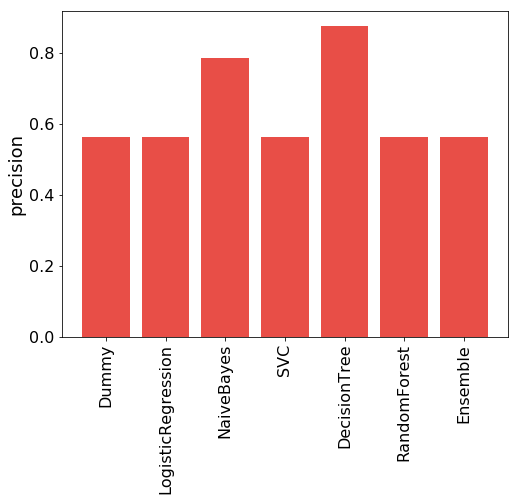

In [58]:
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

### 3.2) General characteristics of VCA process/report

#### 3.2.1) Considers climate change

In [63]:
data_climate = pd.DataFrame(vectors_tfidf_reports_dim65)
data_climate['Climate'] = baseline['Considers climate change']
data_climate.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Climate
30,-0.039004,0.060057,0.347022,-0.091153,-0.032372,0.030452,-0.002567,-0.026956,0.046849,-0.142825,...,0.006959,-0.002742,0.008529,0.001940,-0.004329,0.007149,0.001182,0.000317,9.351335e-16,1
43,-0.051226,0.068850,0.419180,-0.085052,-0.040415,0.016302,-0.001494,0.055178,-0.060566,0.204003,...,0.003245,0.001168,0.019516,-0.012738,-0.022754,0.001871,0.003724,0.001837,9.351335e-16,1
46,0.435999,-0.333335,-0.096734,-0.058260,-0.007066,-0.037990,-0.043022,-0.122349,0.339005,0.158950,...,-0.002242,0.032228,-0.012447,-0.013979,0.011780,0.367458,-0.297909,0.001440,9.351335e-16,1


In [64]:
# well balanced classes :)
print('Proportion of "considers climate" class observations: ',np.round(np.sum(data_climate['Climate'])/len(data_climate), decimals = 3))

Proportion of "considers climate" class observations:  0.585


In [65]:
x_train, x_test, y_train, y_test = train_test_split(data_climate.iloc[:,0:65], data_climate['Climate'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (45, 65) / (20, 65)


In [66]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[1 1 1 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 0 1 0]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.

In [67]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.55      1.00      0.71        11

   micro avg       0.55      0.55      0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20

LogisticRegression
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.79      1.00      0.88        11

   micro avg       0.85      0.85      0.85        20
   macro avg       0.89      0.83      0.84        20
weighted avg       0.88      0.85      0.84        20

NaiveBayes
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         9
           1       0.73      0.73      0.73        11

   micro avg       0.70      0.70      0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


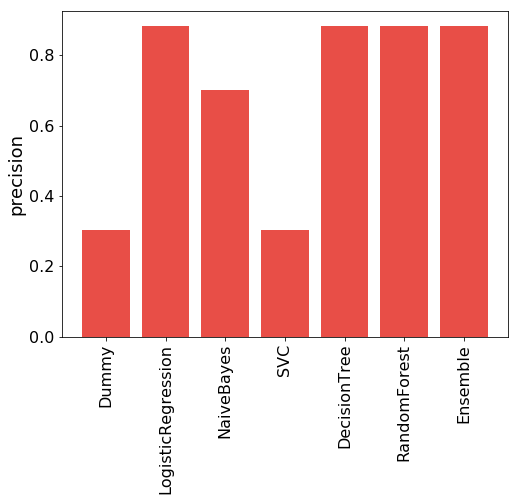

In [68]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

#### 3.2.2) Disaggregate gender

In [69]:
data_gender = pd.DataFrame(vectors_tfidf_reports_dim65)
data_gender['Gender'] = baseline['Disaggregate gender']
data_gender.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Gender
10,0.170861,0.466220,-0.179660,-0.043863,-0.012640,-0.007860,0.010396,-0.001546,0.019989,-0.018934,...,0.005350,-0.005779,0.009429,-0.020491,0.035613,-0.007507,-0.029272,0.001321,9.351335e-16,0
49,0.300208,-0.267844,-0.078409,-0.030790,-0.023025,0.099189,0.001090,0.050306,-0.308164,-0.208238,...,0.025189,0.081484,-0.153669,-0.064443,-0.022176,0.003117,0.000613,0.002628,9.351335e-16,1
58,0.266001,-0.199345,-0.054510,-0.003061,-0.034952,0.010566,0.009736,0.037210,-0.180968,-0.119031,...,-0.015895,0.042185,-0.001804,-0.005081,-0.008457,0.009506,-0.000269,0.000821,9.351335e-16,1


In [70]:
# not-that-bad balanced classes
print('Proportion of "considers gender" class observations: ',np.round(np.sum(data_gender['Gender'])/len(data_gender), decimals = 3))

Proportion of "considers gender" class observations:  0.277


In [71]:
x_train, x_test, y_train, y_test = train_test_split(data_gender.iloc[:,0:65], data_gender['Gender'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s  / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (45, 65)  / (20, 65)


In [72]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.

In [73]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        15
           1       0.00      0.00      0.00         5

   micro avg       0.75      0.75      0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20

LogisticRegression
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        15
           1       1.00      0.20      0.33         5

   micro avg       0.80      0.80      0.80        20
   macro avg       0.89      0.60      0.61        20
weighted avg       0.84      0.80      0.75        20

NaiveBayes
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        15
           1       0.60      0.60      0.60         5

   micro avg       0.80      0.80      0.80        20
   macro avg       0.73      0.73      0.73        20
weighted avg       0.80      0.80     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


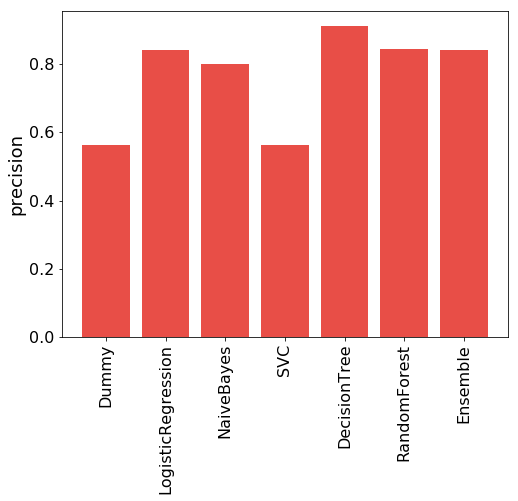

In [74]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

#### 3.2.3) Disaggregate age

In [75]:
data_age = pd.DataFrame(vectors_tfidf_reports_dim65)
data_age['Age'] = baseline['Disaggregate age']
data_age.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Age
33,0.019281,0.041375,0.086577,0.591752,0.028803,-0.007231,-0.028990,-0.020369,0.020921,-0.075410,...,-0.039971,-0.028957,0.000038,-0.015025,-0.002607,0.000934,-0.008758,0.002607,9.351335e-16,0
63,-0.242114,-0.043175,-0.085252,0.021237,-0.059866,-0.093242,-0.139110,-0.094615,-0.042617,0.049522,...,-0.005034,0.029055,0.017829,0.006078,-0.003326,0.018325,0.005003,-0.001903,9.351335e-16,0
16,-0.304351,-0.076043,-0.152761,-0.034064,-0.074541,-0.235117,0.184343,-0.042607,-0.005570,-0.047314,...,0.133530,0.067167,0.068838,0.023453,0.019731,-0.004064,-0.002798,-0.006737,9.351335e-16,0


In [76]:
# not-that-bad balanced classes
print('Proportion of "considers age" class observations: ',np.round(np.sum(data_age['Age'])/len(data_age), decimals = 3))

Proportion of "considers age" class observations:  0.277


In [77]:
x_train, x_test, y_train, y_test = train_test_split(data_age.iloc[:,0:65], data_age['Age'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (45, 65) / (20, 65)


In [78]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.

In [79]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.80      1.00      0.89        16
           1       0.00      0.00      0.00         4

   micro avg       0.80      0.80      0.80        20
   macro avg       0.40      0.50      0.44        20
weighted avg       0.64      0.80      0.71        20

LogisticRegression
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        16
           1       1.00      0.25      0.40         4

   micro avg       0.85      0.85      0.85        20
   macro avg       0.92      0.62      0.66        20
weighted avg       0.87      0.85      0.81        20

NaiveBayes
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        16
           1       0.60      0.75      0.67         4

   micro avg       0.85      0.85      0.85        20
   macro avg       0.77      0.81      0.78        20
weighted avg       0.87      0.85     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


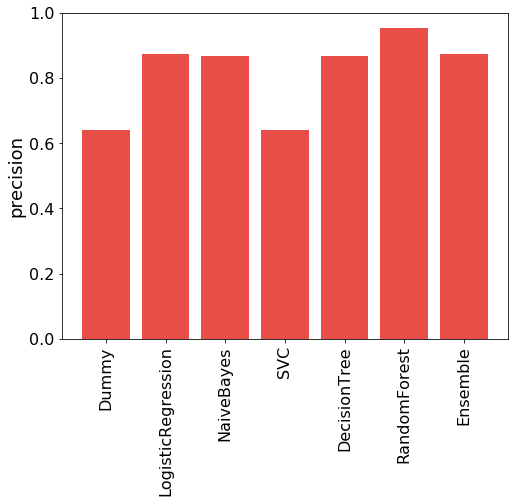

In [80]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

#### 3.2.4) Contains good practices/lessons learned

In [94]:
data_lessons = pd.DataFrame(vectors_tfidf_reports_dim65)
data_lessons['Lessons'] = baseline['Contains good practices/lessons learned']
data_lessons = data_lessons[data_lessons['Lessons'].notnull()]
data_lessons.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Lessons
16,-0.304351,-0.076043,-0.152761,-0.034064,-0.074541,-0.235117,0.184343,-0.042607,-0.005570,-0.047314,...,0.133530,0.067167,0.068838,0.023453,0.019731,-0.004064,-0.002798,-0.006737,9.351335e-16,0.0
17,-0.383493,-0.094145,-0.212004,-0.046401,-0.150786,0.052062,-0.251846,-0.133593,-0.046348,0.016631,...,0.003691,-0.097188,-0.062532,0.011131,-0.016269,-0.005284,-0.003587,-0.004119,9.351335e-16,0.0
1,-0.363748,-0.107417,-0.217384,-0.028779,-0.235657,0.445617,-0.140531,-0.200587,-0.041727,0.063572,...,0.077757,0.411397,0.283198,0.027800,0.051176,-0.010382,-0.005160,-0.001083,9.351335e-16,0.0


In [95]:
# nicely balanced classes
print('Proportion of "contains lessons learned" class observations: ',np.round(np.sum(data_lessons['Lessons'])/len(data_lessons), decimals = 3))

Proportion of "contains lessons learned" class observations:  0.641


In [96]:
x_train, x_test, y_train, y_test = train_test_split(data_lessons.iloc[:,0:65], data_lessons['Lessons'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (44, 65) / (20, 65)


In [97]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
        

In [98]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         5
         1.0       0.75      1.00      0.86        15

   micro avg       0.75      0.75      0.75        20
   macro avg       0.38      0.50      0.43        20
weighted avg       0.56      0.75      0.64        20

LogisticRegression
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00        15

   micro avg       1.00      1.00      1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20

NaiveBayes
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00        15

   micro avg       1.00      1.00      1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


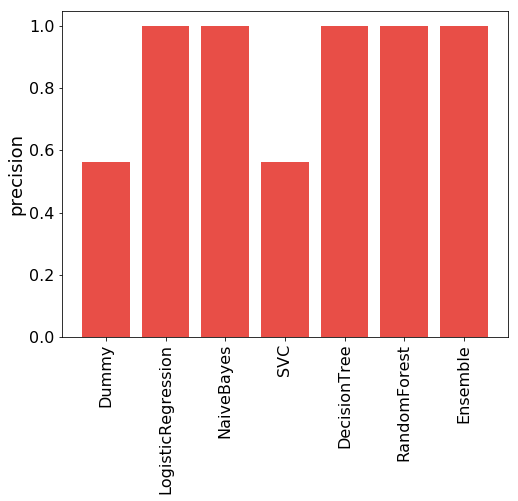

In [99]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

### 3.3) On hazards

#### 3.3.1) Cyclones

In [100]:
data_cyclones = pd.DataFrame(vectors_tfidf_reports_dim65)
data_cyclones['Cyclones'] = baseline['Cyclones']
data_cyclones = data_cyclones[data_cyclones['Cyclones'].notnull()]
data_cyclones['Cyclones'] = data_cyclones['Cyclones'].astype(int)
data_cyclones.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Cyclones
50,0.343198,-0.266832,-0.050946,-0.081413,-0.006905,-0.049212,-0.043275,-0.10167,0.337649,0.156479,...,-0.002735,0.064520,-0.163817,0.380483,0.015722,-0.151324,-0.071362,0.000536,9.351335e-16,1
60,-0.060933,0.061457,0.354315,-0.077857,-0.032112,0.010583,-0.020689,-0.03014,0.018629,-0.104725,...,-0.001282,0.000133,0.003567,0.001609,0.000850,0.001635,0.001236,0.002656,9.351335e-16,1
11,0.177430,0.491629,-0.179082,-0.055194,0.013925,0.010473,-0.008350,0.01683,-0.028719,0.001911,...,-0.034772,0.001777,-0.017112,0.024876,0.006738,0.008668,-0.000593,-0.000091,9.351335e-16,1


In [101]:
#There is just one observation without Cyclones. It's not possible to apply ML!
print('Proportion of cyclones class observations: ',np.round(np.sum(data_cyclones['Cyclones'] == 1)/len(data_cyclones), decimals = 3))

Proportion of cyclones class observations:  0.984


#### 3.3.2) Floods

In [102]:
data_floods = pd.DataFrame(vectors_tfidf_reports_dim65)
data_floods['Floods'] = baseline['Floods']
data_floods = data_floods[data_floods['Floods'].notnull()]
data_floods['Floods'] = data_floods['Floods'].astype(int)
data_floods.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Floods
28,-0.280048,-0.081509,-0.131827,-0.020574,0.014389,-0.419556,-0.408326,0.061705,-0.039007,-0.004892,...,-0.125078,0.055294,-0.011715,-0.014219,0.002767,-0.004338,-0.007874,-0.002645,9.351335e-16,1
12,0.203866,0.516668,-0.206135,-0.048428,-0.016315,0.009895,0.000233,-0.008035,-0.001141,-0.018322,...,0.217275,-0.033470,0.009077,-0.055947,-0.021178,-0.008381,-0.027384,0.000916,9.351335e-16,1
43,-0.051226,0.068850,0.419180,-0.085052,-0.040415,0.016302,-0.001494,0.055178,-0.060566,0.204003,...,0.003245,0.001168,0.019516,-0.012738,-0.022754,0.001871,0.003724,0.001837,9.351335e-16,0


In [103]:
#Classes highly imbalanced...
print('Proportion of floods class observations: ',np.round(np.sum(data_floods['Floods'])/len(data_floods), decimals = 3))

Proportion of floods class observations:  0.905


In [104]:
x_train, x_test, y_train, y_test = train_test_split(data_floods.iloc[:,0:65], data_floods['Floods'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s  / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (44, 65)  / (19, 65)


In [105]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_i

In [106]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.84      1.00      0.91        16

   micro avg       0.84      0.84      0.84        19
   macro avg       0.42      0.50      0.46        19
weighted avg       0.71      0.84      0.77        19

LogisticRegression
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.84      1.00      0.91        16

   micro avg       0.84      0.84      0.84        19
   macro avg       0.42      0.50      0.46        19
weighted avg       0.71      0.84      0.77        19

NaiveBayes
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.84      1.00      0.91        16

   micro avg       0.84      0.84      0.84        19
   macro avg       0.42      0.50      0.46        19
weighted avg       0.71      0.84     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


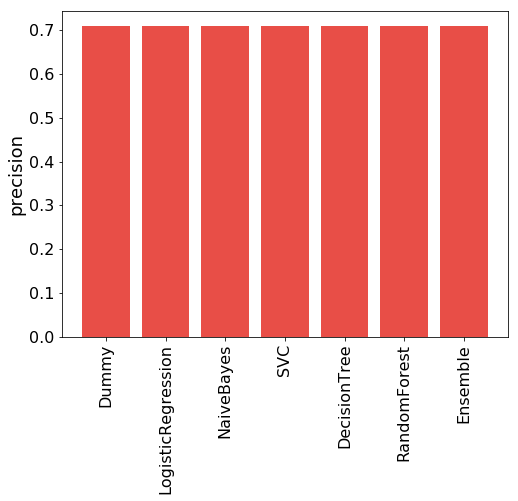

In [107]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

#### 3.3.3) Earthquake

In [108]:
data_earthquake = pd.DataFrame(vectors_tfidf_reports_dim65)
data_earthquake['Earthquake'] = baseline['Earthquake']
data_earthquake = data_earthquake[data_earthquake['Earthquake'].notnull()]
data_earthquake['Earthquake'] = data_earthquake['Earthquake'].astype(int)
data_earthquake.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Earthquake
56,0.289831,-0.229470,-0.047319,-0.062085,-0.000144,0.006018,-0.008942,0.039862,-0.069806,-0.040073,...,-0.036855,-0.013976,-0.028463,0.040563,-0.004026,-0.035063,-0.021601,-0.000971,9.351335e-16,0
57,0.207353,-0.138645,-0.045516,-0.012617,-0.005792,0.004517,0.035247,0.035658,-0.101697,-0.036679,...,-0.007247,-0.016849,0.018183,0.041803,-0.008368,-0.003596,-0.007281,0.002616,9.351335e-16,1
11,0.177430,0.491629,-0.179082,-0.055194,0.013925,0.010473,-0.008350,0.016830,-0.028719,0.001911,...,-0.034772,0.001777,-0.017112,0.024876,0.006738,0.008668,-0.000593,-0.000091,9.351335e-16,1


In [109]:
#Classes nicely balanced :)
print('Proportion of earthquake class observations: ',np.round(np.sum(data_earthquake['Earthquake'])/len(data_earthquake), decimals = 3))

Proportion of earthquake class observations:  0.46


In [110]:
TEST_SPLIT = 0.2

In [111]:
x_train, x_test, y_train, y_test = train_test_split(data_earthquake.iloc[:,0:65], data_earthquake['Earthquake'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s / %s" % (str(x_train.shape),  str(x_test.shape)))

TFIDF vectors Train/Test shapes : (50, 65) / (13, 65)


In [112]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[0 0 0 0 0 0 0 0 0 0 0 0 0]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[0 0 1 0 0 0 0 1 0 0 0 1 0]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[0 1 1 0 0 0 1 1 0 0 0 1 0]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf

In [113]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.54      1.00      0.70         7
           1       0.00      0.00      0.00         6

   micro avg       0.54      0.54      0.54        13
   macro avg       0.27      0.50      0.35        13
weighted avg       0.29      0.54      0.38        13

LogisticRegression
              precision    recall  f1-score   support

           0       0.50      0.71      0.59         7
           1       0.33      0.17      0.22         6

   micro avg       0.46      0.46      0.46        13
   macro avg       0.42      0.44      0.41        13
weighted avg       0.42      0.46      0.42        13

NaiveBayes
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.40      0.33      0.36         6

   micro avg       0.46      0.46      0.46        13
   macro avg       0.45      0.45      0.45        13
weighted avg       0.45      0.46     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


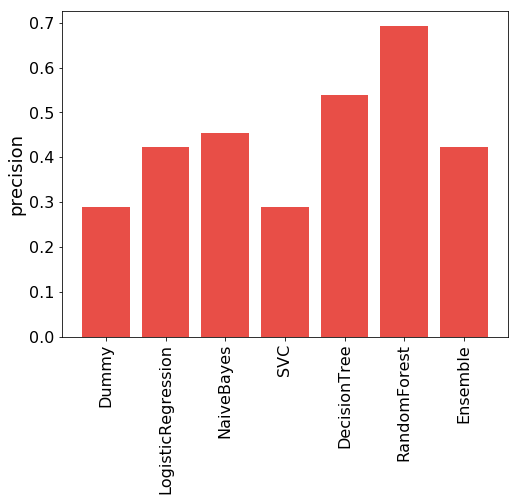

In [114]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

#### 3.3.4) Drought

In [122]:
data_drought = pd.DataFrame(vectors_tfidf_reports_dim65)
data_drought['Drought'] = baseline['Drought']
data_drought = data_drought[data_drought['Drought'].notnull()]
data_drought['Drought'] = data_drought['Drought'].astype(int)
data_drought.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Drought
20,-0.210700,-0.027554,-0.079870,-0.031737,0.034233,-0.290862,0.462228,-0.331929,-0.081201,-0.038153,...,-0.023195,-0.033448,-0.035975,-0.008486,-0.004872,0.007039,-0.001026,-0.002630,9.351335e-16,0
37,-0.036895,0.070082,0.385997,-0.107435,-0.051307,0.018583,-0.006310,-0.073386,0.055633,-0.162336,...,-0.009296,0.005334,0.000056,0.005610,-0.003969,-0.001577,0.000533,0.001900,9.351335e-16,1
12,0.203866,0.516668,-0.206135,-0.048428,-0.016315,0.009895,0.000233,-0.008035,-0.001141,-0.018322,...,0.217275,-0.033470,0.009077,-0.055947,-0.021178,-0.008381,-0.027384,0.000916,9.351335e-16,1


In [123]:
#Classes nicely balanced :)
print('Proportion of drought class observations: ',np.round(np.sum(data_drought['Drought'])/len(data_drought), decimals = 3))

Proportion of drought class observations:  0.397


In [124]:
TEST_SPLIT = 0.2

In [125]:
x_train, x_test, y_train, y_test = train_test_split(data_drought.iloc[:,0:65], data_drought['Drought'], test_size=TEST_SPLIT, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s / %s" % (str(x_train.shape), str(x_test.shape)))

TFIDF vectors Train/Test shapes : (40, 65) / (13, 65)


In [126]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[0 0 0 0 0 0 0 0 0 0 0 0 0]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[0 0 1 1 0 0 0 0 1 1 0 0 0]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf

In [127]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       0.00      0.00      0.00         5

   micro avg       0.62      0.62      0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13

LogisticRegression
              precision    recall  f1-score   support

           0       0.62      1.00      0.76         8
           1       0.00      0.00      0.00         5

   micro avg       0.62      0.62      0.62        13
   macro avg       0.31      0.50      0.38        13
weighted avg       0.38      0.62      0.47        13

NaiveBayes
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.25      0.20      0.22         5

   micro avg       0.46      0.46      0.46        13
   macro avg       0.40      0.41      0.41        13
weighted avg       0.44      0.46     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


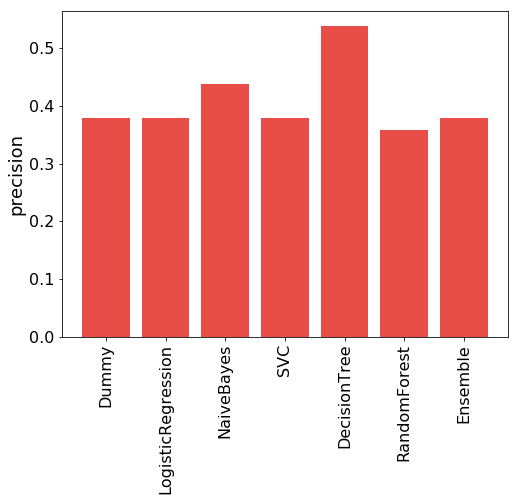

In [128]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

#### 3.3.5) Tsunami

In [129]:
data_tsunami = pd.DataFrame(vectors_tfidf_reports_dim65)
data_tsunami['Tsunami'] = baseline['Tsunami']
data_tsunami = data_tsunami[data_tsunami['Tsunami'].notnull()]
data_tsunami['Tsunami'] = data_tsunami['Tsunami'].astype(int)
data_tsunami.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,Tsunami
43,-0.051226,0.068850,0.419180,-0.085052,-0.040415,0.016302,-0.001494,0.055178,-0.060566,0.204003,...,0.003245,0.001168,0.019516,-0.012738,-0.022754,0.001871,0.003724,0.001837,9.351335e-16,0
12,0.203866,0.516668,-0.206135,-0.048428,-0.016315,0.009895,0.000233,-0.008035,-0.001141,-0.018322,...,0.217275,-0.033470,0.009077,-0.055947,-0.021178,-0.008381,-0.027384,0.000916,9.351335e-16,0
34,0.050405,0.026492,0.084558,0.647190,0.040860,0.003230,-0.001921,-0.057653,0.040895,-0.088922,...,-0.174505,0.016399,-0.001551,-0.001265,0.032932,0.018444,-0.001609,0.003281,9.351335e-16,0


In [130]:
#Classes highly imbalanced
print('Proportion of tsunami class observations: ',np.round(np.sum(data_tsunami['Tsunami'])/len(data_tsunami), decimals = 3))

Proportion of tsunami class observations:  0.127


In [131]:
TEST_SPLIT = 0.3

In [132]:
x_train, x_test, y_train, y_test = train_test_split(data_tsunami.iloc[:,0:65], data_tsunami['Tsunami'], test_size=TEST_SPLIT, random_state=42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=TEST_SPLIT, random_state=43)

#total number of observations
print ("TFIDF vectors Train/Test shapes : %s /  %s" % (str(x_train.shape),  str(x_test.shape)))

TFIDF vectors Train/Test shapes : (44, 65) /  (19, 65)


In [133]:
#Train models
modelnames = ['Dummy','LogisticRegression','NaiveBayes','SVC','DecisionTree','RandomForest','Ensemble']
yhat = {}
for modelname in modelnames:
    print (modelname)
    model = train(x_train, y_train, modelname)
    print (model)
    
    yhat[modelname] = model.predict(x_test)
    print (yhat[modelname])
    
print ('done!')

Dummy
DummyClassifier(constant=None, random_state=None, strategy='most_frequent')
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
LogisticRegression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
NaiveBayes
GaussianNB(priors=None, var_smoothing=1e-09)
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
SVC
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
DecisionTree
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_i

In [134]:
# Now evaluate
results={}
for modelname in yhat:
    print (modelname)
    results[modelname] = classification_report(y_test, yhat[modelname], output_dict=True)
    print (classification_report(y_test, yhat[modelname]))

Dummy
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       0.00      0.00      0.00         2

   micro avg       0.89      0.89      0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

LogisticRegression
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        17
           1       0.00      0.00      0.00         2

   micro avg       0.89      0.89      0.89        19
   macro avg       0.45      0.50      0.47        19
weighted avg       0.80      0.89      0.85        19

NaiveBayes
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        17
           1       0.50      0.50      0.50         2

   micro avg       0.89      0.89      0.89        19
   macro avg       0.72      0.72      0.72        19
weighted avg       0.89      0.89     

C:\Users\Paola.YELA\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


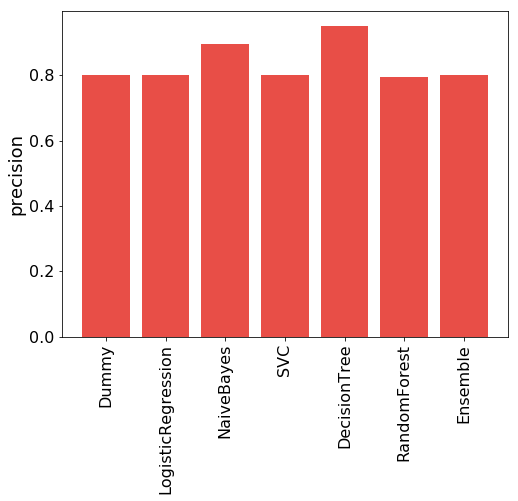

In [135]:
#Now plot
EVAL_AVGTYPE = 'weighted avg'
EVAL_MEASURE = 'precision'

fig = plt.figure(figsize=(8,6)) 

labels = modelnames
data = [results[x][EVAL_AVGTYPE][EVAL_MEASURE] for x in labels]

plt.bar(labels, data, color='#E32219',alpha = .8)
    
plt.ylabel(EVAL_MEASURE, fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=12)
plt.xticks(rotation=90)

plt.show()

## Previous approach

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
#The data
corpus_root = 'data/data_simplified'

Load the VCA reports in Philippines

In [ ]:
reports = list()
reports_title = list()
for report_file in os.listdir(corpus_root+'/Asia Pacific/Philippines/Assessment Reports'):
    if ".txt" in report_file:
        print(report_file)
        with codecs.open(os.path.join(corpus_root+'/Asia Pacific/Philippines/Assessment Reports',report_file),encoding="utf8", errors='ignore') as f:
            reports.append(f.read())
            reports_title.append(report_file)

Print the beginning of the VCA report done in Bakhaw Nort

In [ ]:
print(reports[0][1380:1480])

#### Let's remove the new lines

In [ ]:
reports = [" ".join(r.split()) for r in reports]

In [ ]:
print(reports[20][0:1700])

In [ ]:
count = 0
for r in reports:
    if("typhoon" in r):
        print (reports_title[reports.index(r)]) 
        count = count + 1
print("Total reports reporting typhoon: ",count," over ",len(reports)," total number of reports")

## 1. Extraction of information based in dictionaries

In [ ]:
dictionaries_root = 'data/data_dictionaries/'

### 1.1 Simple classification

Reading dictionaries for classify if the report meets a condition or not.

In [ ]:
simple_dictionaries = list()
simple_dictionaries_title = list()
for dictionary_file in os.listdir(dictionaries_root):
    if ".txt" in dictionary_file:
        print(dictionary_file)
        with codecs.open(os.path.join(dictionaries_root,dictionary_file),encoding="utf8", errors='ignore') as d:
            ### split by new row
            simple_dictionaries.append(d.read().split("\r\n"))
            simple_dictionaries_title.append(dictionary_file)

#### 1.1.1 Is the report age disaggregated?

In [ ]:
age_filter = simple_dictionaries[1]

In [ ]:
age_filter

In [ ]:
count = 0
for r in reports:
    if any(word in r for word in age_filter):
        print (reports_title[reports.index(r)]) 
        count = count + 1
print("Total reports that are age disaggregated: ",count," over ",len(reports)," total number of reports")

 #### 1.1.2 Is the report gender disaggregated?

In [ ]:
gender_filter = simple_dictionaries[4]

In [ ]:
gender_filter

In [ ]:
count = 0
for r in reports:
    if any(word in r for word in gender_filter):
        print (reports_title[reports.index(r)]) 
        count = count + 1
print("Total reports that are gender disaggregated: ",count," over ",len(reports)," total number of reports")

 #### 1.1.3 Does the report consider diversity?

In [ ]:
diversity_filter = simple_dictionaries[2]

In [ ]:
diversity_filter

In [ ]:
count = 0
for r in reports:
    if any(word in r for word in diversity_filter):
        print (reports_title[reports.index(r)]) 
        count = count + 1
print("Total reports that consider diversity: ",count," over ",len(reports)," total number of reports")

 #### 1.1.4 Does the report show exposed areas?

In [ ]:
exposure_filter = simple_dictionaries[3]

In [ ]:
exposure_filter

In [ ]:
count = 0
for r in reports:
    if any(word in r for word in exposure_filter):
        print (reports_title[reports.index(r)]) 
        count = count + 1
print("Total reports that show exposed areas: ",count," over ",len(reports)," total number of reports")

 #### 1.1.5 Does the report have a plan of action?

In [ ]:
plan_filter = simple_dictionaries[0]

In [ ]:
plan_filter

In [ ]:
count = 0
for r in reports:
    if any(word in r for word in plan_filter):
        print (reports_title[reports.index(r)]) 
        count = count + 1
print("Total reports that have a plan of action: ",count," over ",len(reports)," total number of reports")